# Training a Model on Encrypted Data

In [1]:
import sys
import torch
import torchvision
import matplotlib.pyplot as plt


# python 3.7 is required
assert sys.version_info[0] == 3 and sys.version_info[1] == 7, "python 3.7 is required"

import crypten
crypten.init()

%matplotlib inline

## MNIST

In [2]:
digits = torchvision.datasets.MNIST(root='/tmp/data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

digits_test = torchvision.datasets.MNIST(root='/tmp/data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

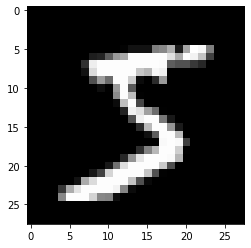

In [3]:
plt.imshow(digits[0][0][0], cmap='gray', interpolation='none')

In [4]:
print("label for image is ", digits[0][1])

label for image is  5


## Preprocess Into Tensors

In [5]:
def take_samples(digits, n_samples=1000):
    """Returns images and labels based on sample size"""
    images, labels = [], []

    for i, digit in enumerate(digits):
        if i == n_samples:
            break
        image, label = digit
        images.append(image)
        label_one_hot = torch.nn.functional.one_hot(torch.tensor(label), 10)
        labels.append(label_one_hot)

    images = torch.cat(images)
    labels = torch.stack(labels)
    return images, labels
    

In [6]:
images, labels = take_samples(digits, n_samples=100)

In [7]:
print(images.shape)
print(labels.shape)

torch.Size([100, 28, 28])
torch.Size([100, 10])


In [8]:
images_enc = crypten.cryptensor(images)
labels_enc = crypten.cryptensor(labels)

In [9]:
images_enc[0]

MPCTensor(
	_tensor=tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
     

In [10]:
# test set
images_test, labels_test = take_samples(digits_test, n_samples=20)
images_test_enc = crypten.cryptensor(images_test)
labels_test_enc = crypten.cryptensor(labels_test)

## Logistic Regression Model

(multiclass logistic regression)

In [12]:
class LogisticRegression(crypten.nn.Module):
    
    def __init__(self):
        super().__init__()
        # images are 28x28 pixels
        self.linear = crypten.nn.Linear(28 * 28, 10)
        
    def forward(self, x):
        return self.linear(x)
        
    

In [13]:
model = LogisticRegression().encrypt()

In [14]:
model(images_enc)

### Train Model on Encrypted Images

In [16]:
def train_model(model, X, y, epochs=10, learning_rate=0.05):
    criterion = crypten.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        print(f"epoch {epoch} loss: {loss.get_plain_text()}")
        loss.backward()
        model.update_parameters(learning_rate)
    return model

In [17]:
model = train_model(model, images_enc, labels_enc)

epoch 0 loss: 2.332916259765625
epoch 1 loss: 2.2252349853515625
epoch 2 loss: 2.1306304931640625
epoch 3 loss: 2.0459747314453125
epoch 4 loss: 1.968963623046875
epoch 5 loss: 1.89739990234375
epoch 6 loss: 1.8313140869140625
epoch 7 loss: 1.7688751220703125
epoch 8 loss: 1.7100067138671875
epoch 9 loss: 1.6540679931640625


### Decrypt Prediction

In [18]:
prediction = model(images_enc[3].unsqueeze(0))

In [19]:
prediction.get_plain_text().argmax()

tensor(1)

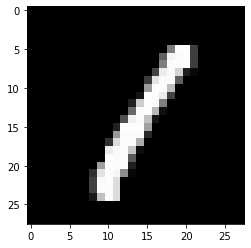

In [20]:
plt.imshow(images[3], cmap='gray', interpolation='none')

### Test Model Accuracy

In [21]:
def avg_test_accuracy(model, X, y):    
    output = model(X).get_plain_text().softmax(0)
    predicted = output.argmax(1)
    labels = y.get_plain_text().argmax(1)
    correct = (predicted == labels).sum().float()
    return float(correct / y.shape[0])

In [22]:
avg_test_accuracy(model, images_enc, labels_enc)

0.8799999952316284

## Training a CNN

based on https://github.com/pytorch/examples/blob/master/mnist/main.py

In [23]:
class CNN(crypten.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = crypten.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = crypten.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = crypten.nn.Dropout2d(0.25)
        self.dropout2 = crypten.nn.Dropout2d(0.5)
        self.fc1 = crypten.nn.Linear(9216, 128)
        self.fc2 = crypten.nn.Linear(128, 10)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = x.relu()
        x = self.conv2(x)
        x = x.relu()
        x = x.max_pool2d(2)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = x.relu()
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [24]:
model = CNN().encrypt()

In [25]:
x = images_enc[0].unsqueeze(0)
print(x.shape)
model(x)

torch.Size([1, 28, 28])


In [26]:
model = train_model(model, images_enc[:10, ], labels_enc[:10,], epochs=3)

epoch 0 loss: 2.3135986328125
epoch 1 loss: 2.2531890869140625
epoch 2 loss: 2.1912384033203125


In [27]:
prediction = model(images_enc[3].unsqueeze(0)).argmax()

# Importing PyTorch Models

In [28]:
import torch.nn as nn
import torch.nn.functional as F


class PyTorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [29]:
pytorch_model = PyTorchModel()

In [30]:
dummy_input = torch.empty(images.shape)
crypten_model = crypten.nn.from_pytorch(pytorch_model, dummy_input)
crypten_model.encrypt()

In [34]:
prediction = crypten_model(images_enc[3].unsqueeze(0))
print(prediction)

In [35]:
print(prediction.get_plain_text())

tensor([[-2.2325, -2.2288, -2.2988, -2.3620, -2.2741, -2.2421, -2.4341, -2.2122,
         -2.2984, -2.3620]])


In [36]:
prediction.get_plain_text().argmax()

tensor(7)

In [37]:
crypten_model = train_model(crypten_model, images_enc[:10, ], labels_enc[:10,], epochs=3)

epoch 0 loss: 2.3262786865234375
epoch 1 loss: 2.287811279296875
epoch 2 loss: 2.182342529296875
